--------------
**Ranking Txn in Subnetworks**

--------------

In [1]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict

# GCP libraries
from pandas_gbq import to_gbq # write pandas df to a GCP BigQuery table
import gcsfs
import importlib.util
import os
import inspect

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


--------------
##### Read in Datasets
--------------


In [2]:
# Get subnetwork table
%%bigquery df_txn_features
select * from `extreme-torch-467913-m6.txn.txn_features_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
df_txn_features.head(1)

,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,pred_model,pred_model_threshold,pred_proba,pred_class,pred_class_label,final_class,final_class_label
0,30549576,8,3,Unknown,-0.1700,-0.1805,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.1606,-0.1665,-0.0497,-0.1629,-0.0287,-0.0354,-0.0430,-0.0133,-0.0542,-0.1684,-0.1700,-0.1728,-1.3737,-1.3715,-0.1397,-0.1489,-0.0801,-0.1557,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1557,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.

In [4]:
# Get subnetwork table
%%bigquery df_network_edges
select * from `extreme-torch-467913-m6.networks.network_edges_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
df_network_edges.head(1)

,merged_subnetwork_id,src_txn_id,dst_txn_id,min_src_hop,min_dst_hop
0,0,3084073,230658142,0,1


In [6]:
# Get txn subnetwork table
%%bigquery df_nw_txn_final
select * from `extreme-torch-467913-m6.networks.network_txn_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
df_nw_txn_final.head(1)

,merged_subnetwork_id,txn_id,min_hop,seeds_in_group
0,0,3084073,0,"[3084073, 9907558, 36385394, 39915271, 2303317..."


In [8]:
# Get subnetwork summary table
%%bigquery df_nw_summary
select * from `extreme-torch-467913-m6.networks.network_summary`;

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
df_nw_summary.head(1)

,merged_subnetwork_id,txn_ids,node_count,edge_count,depth,seeds,seed_count,linked_txn_count
0,17742,"[101586718, 130897027, 138779422, 162026612, 1...",394,438,15,"[130897027, 176149522, 298005149, 306112320, 3...",223,171


--------------
##### Read in Txn Subnetwork Classes & Modules
--------------


In [24]:
# Define bucket and file path
bucket_name = "thesis_classes"
file_name = "txn_rank.py"
gcs_path = f"gs://{bucket_name}/{file_name}"

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Local filename to save the script temporarily
local_file = f"/tmp/{file_name}"

# Download the file from GCS to local storage
fs.get(gcs_path, local_file)

# Dynamically import the module
module_name = "txn_subnetworks"
spec = importlib.util.spec_from_file_location(module_name, local_file)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [25]:
# Use inspect to get classes and functions
classes = [name for name, obj in inspect.getmembers(module, inspect.isclass)]

# Print results
print("Classes in module:")
for cls in classes:
    print(f"  - {cls}")


Classes in module:
  - build_txn_rank
  - defaultdict
  - ranking_comparison


In [26]:
# Instantiate the classes
build_rank = module.build_txn_rank()
build_comp = module.ranking_comparison()

--------------
##### Build Composite Rank Calculation

--------------


In [13]:
df_pr = build_rank.build_pagerank(
    df_edges=df_network_edges,
    group='merged_subnetwork_id',
    src='src_txn_id',
    dst='dst_txn_id',
    weight_col=None,           # unweighted
    alpha=0.85, max_iter=100, tol=1e-8
)

In [14]:
df_pr.head(1)

,merged_subnetwork_id,node,pagerank,pr_rank
0,0,230658142,0.3244,1


In [15]:
df_composite, used_weights = build_rank.build_composite_calc(
    df_txn_features=df_txn_features,
    df_pr=df_pr,
    df_nw_txn_final=df_nw_txn_final,
    nw_txn_col='txn_id',
    group_col='merged_subnetwork_id',
    feats_txid_col='txId',
    pr_node_col='node',
    pr_value_col='pagerank',
    weights={'pr':0.60,'val':0.30,'in':0.07,'out':0.03},
    invert_out_deg=True
)

print("weights used:", used_weights)
display(df_composite.head())


weights used: {'pr': 0.6, 'val': 0.3, 'in': 0.07, 'out': 0.03}


,merged_subnetwork_id,node,in_BTC_total,in_txs_degree,out_txs_degree,pagerank,pagerank_pct,pagerank_pct_filled_for_contrib,in_btc_pct,in_deg_pct,out_deg_pct,out_deg_pct_inv,in_btc_share,pr_weight,val_weight,in_weight,out_weight,pr_contrib,val_contrib,in_deg_contrib,out_deg_contrib,composite_raw,composite_pct,composite_rank,pagerank_missing
0,0,3084073,0.0000,0,0,0.0177,0.4355,0.4355,0.0645,0.4032,0.1129,0.8871,0.0000,0.6000,0.3000,0.0700,0.0300,0.2613,0.0194,0.0282,0.0266,0.3355,0.0645,29,False
1,0,9907558,0.0000,0,0,0.0177,0.4355,0.4355,0.0645,0.4032,0.1129,0.8871,0.0000,0.6000,0.3000,0.0700,0.0300,0.2613,0.0194,0.0282,0.0266,0.3355,0.0645,29,False
2,0,36385394,0.0943,0,1,0.0177,0.4355,0.4355,0.6129,0.4032,0.4032,0.5968,0.0061,0.6000,0.3000,0.0700,0.0300,0.2613,0.1839,0.0282,0.0179,0.4913,0.5806,14,False
3,0,39915271,0.4525,0,1,0.0177,0.4355,0.4355,0.9032,0.4032,0.4032,0.5968,0.0294,0.6000,0.3000,0.0700,0.0300,0.2613,0.2710,0.0282,0.0179,0.5784,0.8065,7,False
4,0,230331777,0.0435,0,2,0.0177,0.4355,0.4355,0.5161,0.4032,0.8065,0.1935,0.0028,0.6000,0.3000,0.0700,0.0300,0.2613,0.1548,0.0282,0.0058,0.4502,0.4516,18,False


In [16]:
df_composite.shape

(49707, 25)

--------------
##### Compare Composite Rank to other Ranking Methods
--------------


In [17]:
# Build structural baselines
df_hits = build_rank.build_hits(df_network_edges)          # HITS hub/authority + ranks
df_deg  = build_rank.build_degrees(df_network_edges)       # in/out degree + ranks
df_cent = build_rank.build_centralities(df_network_edges)  # betweenness/harmonic/eigenvector/katz/coreness + ranks
df_hops = build_rank.build_min_hops(df_network_edges)      # min hop per node


In [18]:
for _df in [df_composite, df_pr, df_hits, df_deg, df_cent, df_hops]:
    _df['merged_subnetwork_id'] = _df['merged_subnetwork_id'].astype(str)
    _df['node'] = _df['node'].astype(str)

In [19]:
# Combine the structural baselines
df_all = (
    df_composite
    .merge(df_pr[['merged_subnetwork_id','node','pr_rank']], on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_hits, on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_deg[['merged_subnetwork_id','node','rank_inDeg','rank_outDeg']],  on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_cent, on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_hops, on=['merged_subnetwork_id', 'node'], how='left')
)

# 5) Sort strictly by composite rank ascending within each subnetwork
df_all = (df_all
          .sort_values(['merged_subnetwork_id','composite_rank'], ascending=[True, True], na_position='last')
          .reset_index(drop=True))

Correlation at a Subnetwork Level

In [20]:
print(df_all.shape)
df_all.head(1)

(49707, 43)


,merged_subnetwork_id,node,in_BTC_total,in_txs_degree,out_txs_degree,pagerank,pagerank_pct,pagerank_pct_filled_for_contrib,in_btc_pct,in_deg_pct,out_deg_pct,out_deg_pct_inv,in_btc_share,pr_weight,val_weight,in_weight,out_weight,pr_contrib,val_contrib,in_deg_contrib,out_deg_contrib,composite_raw,composite_pct,composite_rank,pagerank_missing,pr_rank,hub_score,authority_score,hub_rank,authority_rank,rank_inDeg,rank_outDeg,betweenness,harmonic,eigenvector,katz,coreness,rank_betw,rank_harm,rank_eig,rank_katz,rank_coreness,hop
0,0,230658142,3.5091,134,0,0.3244,1.0000,1.0000,0.9677,1.0000,0.1129,0.8871,0.2278,0.6000,0.3000,0.0700,0.0300,0.6000,0.2903,0.0700,0.0266,0.9869,1.0000,1,False,1.0000,0.0000,1.0000,2.0000,1.0000,1.0000,1.0000,0.0000,20.5000,0.7060,0.4670,1.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1


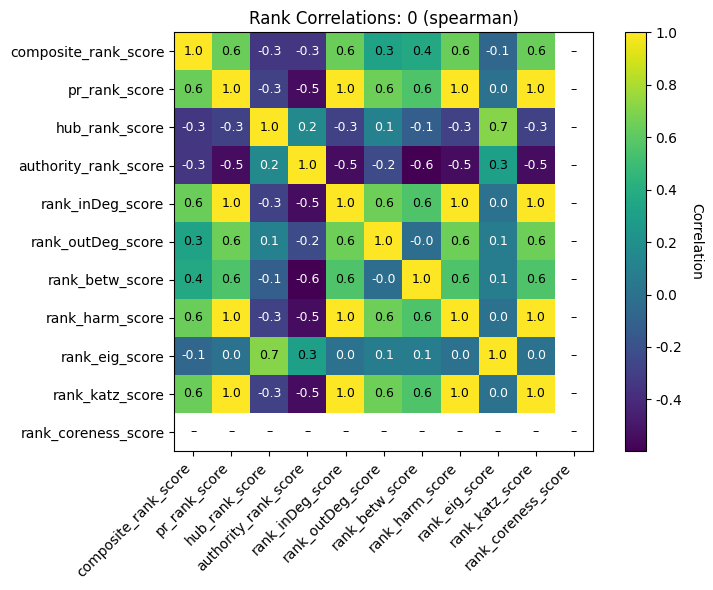

In [21]:
rank_cols = [
    'composite_rank','pr_rank','hub_rank','authority_rank',
    'rank_inDeg','rank_outDeg','rank_betw','rank_harm','rank_eig','rank_katz','rank_coreness'
]

spearman_corrs = build_comp.corr_matrices_per_group(
    df_all,
    method='spearman',
    rank_cols=rank_cols,
    min_nodes=5
)

gid = list(spearman_corrs.keys())[0]
mat = build_comp.plot_group_corr(
    df_all, gid=gid, method='spearman',
    rank_cols=[c for c in rank_cols if c in df_all.columns], min_nodes=5
)

Correlation at a global level (all subnetworks)

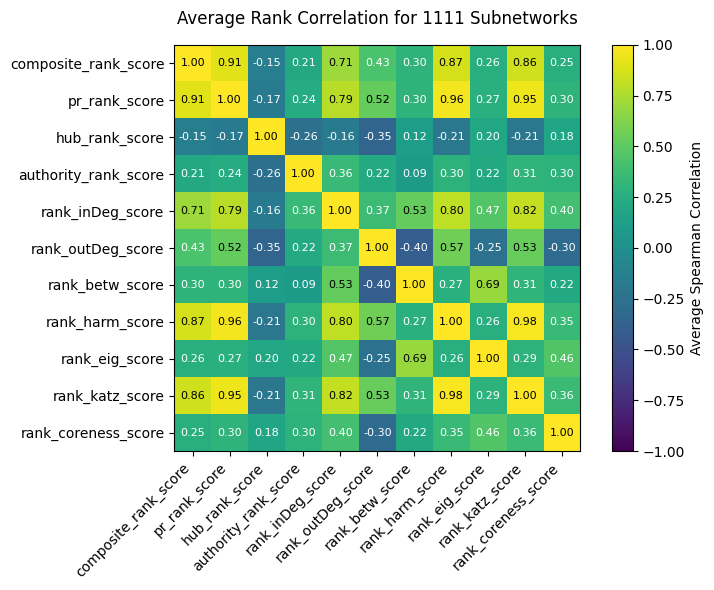

In [22]:
avg_mat, n_subnetworks = build_comp.average_corr_matrix(
    spearman_corrs,
    df_nw_summary=df_nw_summary,
    min_nodes=5
)

build_comp.plot_avg_corr(avg_mat, n_subnetworks)

Justification of Composite Calculation Weightings

In [27]:
# Compare different weights
weights = [
    # --- Baseline and balanced ---
    {"name": "equal",       "pr": 0.25, "val": 0.25, "in": 0.25, "out": 0.25},
    {"name": "balanced",    "pr": 0.50, "val": 0.40, "in": 0.07, "out": 0.03},  # mild bias toward PR/Val balance
    {"name": "current",     "pr": 0.60, "val": 0.30, "in": 0.07, "out": 0.03},  # your existing choice

    # --- PR-dominant variations ---
    {"name": "pr_heavy",    "pr": 0.70, "val": 0.20, "in": 0.07, "out": 0.03},  # strong structural focus
    {"name": "pr_extreme",  "pr": 0.80, "val": 0.15, "in": 0.03, "out": 0.02},  # almost pure influence
    {"name": "pr_mid",      "pr": 0.55, "val": 0.35, "in": 0.07, "out": 0.03},  # small step toward value

    # --- Value-dominant variations ---
    {"name": "val_heavy",   "pr": 0.20, "val": 0.70, "in": 0.06, "out": 0.04},  # strong value focus
    {"name": "val_mid",     "pr": 0.40, "val": 0.50, "in": 0.06, "out": 0.04},  # moderate value emphasis
    {"name": "val_extreme", "pr": 0.10, "val": 0.80, "in": 0.05, "out": 0.05},  # nearly pure monetary flow

    # --- Degree-emphasised variants (for testing structural noise) ---
    {"name": "deg_heavy",   "pr": 0.40, "val": 0.30, "in": 0.20, "out": 0.10},  # boosts degree importance
    {"name": "deg_equal",   "pr": 0.33, "val": 0.33, "in": 0.17, "out": 0.17},  # even split among all metrics
]

summary, details = build_comp.compare_weights_top_fraction(
          df_txn_features=df_all,
     df_pr=df_all[["node","pagerank"]],
     df_nw_txn_final=df_all[["merged_subnetwork_id","node"]].rename(columns={"node":"txn_id"}),
     nw_txn_col="txn_id",
     group_col="merged_subnetwork_id",
     weights_list=weights,
     top_frac=0.20,
     min_nodes=5,
     return_details=True
 )


→ Evaluating weights: equal
→ Evaluating weights: balanced
→ Evaluating weights: current
→ Evaluating weights: pr_heavy
→ Evaluating weights: pr_extreme
→ Evaluating weights: pr_mid
→ Evaluating weights: val_heavy
→ Evaluating weights: val_mid
→ Evaluating weights: val_extreme
→ Evaluating weights: deg_heavy
→ Evaluating weights: deg_equal


In [28]:
summary

,weight_set,median_BTC_share,median_PR_percentile,n_subnetworks,top_frac
0,pr_extreme,0.2267,92.8571,1111,0.2000
1,pr_heavy,0.2395,92.3077,1111,0.2000
2,current,0.2637,91.6667,1111,0.2000
3,pr_mid,0.2753,91.6667,1111,0.2000
4,deg_heavy,0.2763,91.3793,1111,0.2000
5,balanced,0.2842,91.1765,1111,0.2000
6,equal,0.2742,90.0000,1111,0.2000
7,deg_equal,0.2853,90.0000,1111,0.2000
8,val_mid,0.3662,75.0000,1111,0.2000
9,val_heavy,0.4666,46.4286,1111,0.2000


In [29]:
details["current"].head()

,subnet,btc_share,pr_percentile_med,n_nodes,k_selected
0,0,0.8959,88.7097,31,7
1,1006,0.1286,100.0000,5,1
2,10109,0.2564,92.8571,7,2
3,10283,0.1472,100.0000,5,1
4,10298,0.0054,100.0000,5,1


--------------
##### Export Ranking Tables to BigQuery
--------------


In [30]:
# Define your project ID
#project_id = 'extreme-torch-467913-m6'
#to_gbq(dataframe = df_composite, destination_table = 'networks.network_txn_rank', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 9157.87it/s]
